# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import random


# Question 1

### i) How many rows (samples) and columns (features) are present in the dataset?

### Ans:

In [7]:
df = pd.read_csv('../data/Project1-ClassificationDataset.csv')

print(f'There are {df.shape[0]} rows (samples) in the dataset.')
print(f'There are {df.shape[1]} columns (features) in the dataset.')


There are 3476 rows (samples) in the dataset.
There are 8 columns (features) in the dataset.


### ii)  Plot 3 histograms on : 

### (a) The total number of alpha-numeric characters per data point (row) in the feature full text: i.e count on the x-axis and frequency on the y-axis;

### (b) The column leaf_label–class on the x-axis;

### (c) The column root_label–class on the x-axis;


### Ans (a):

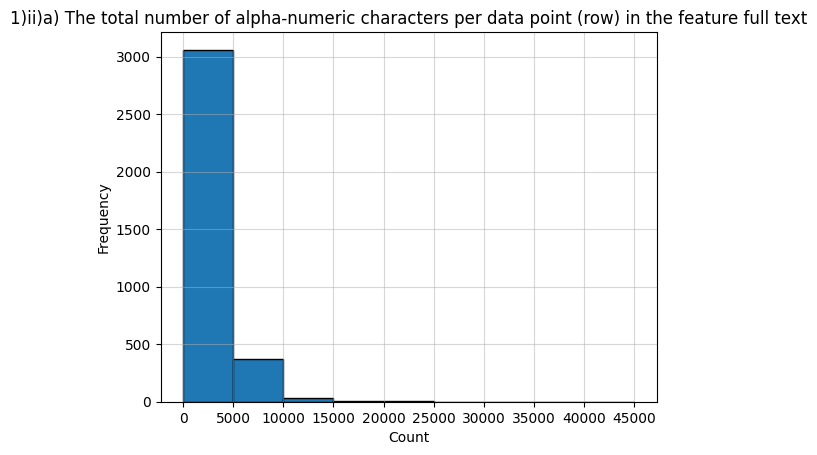

['3060', '369', '35', '8', '2', '0', '1', '0', '1']


In [51]:
alpha_numeric_characters_per_row = df['full_text'].apply(
    lambda row: sum(char.isalnum() for char in str(row))
).tolist()
counts, _, _ = plt.hist(
    alpha_numeric_characters_per_row,
    bins = np.linspace(0,45000,10,True),
    edgecolor = 'black'
)
plt.grid(axis='y', alpha=0.5)
plt.grid(axis='x', alpha=0.5)
plt.xticks(np.linspace(0,45000,10,True))
plt.title('1)ii)a) The total number of alpha-numeric characters per data point (row) in the feature full text')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.show()

print([f"{count:.0f}" for count in counts])


### Ans (b):

Text(0, 0.5, 'Frequency')

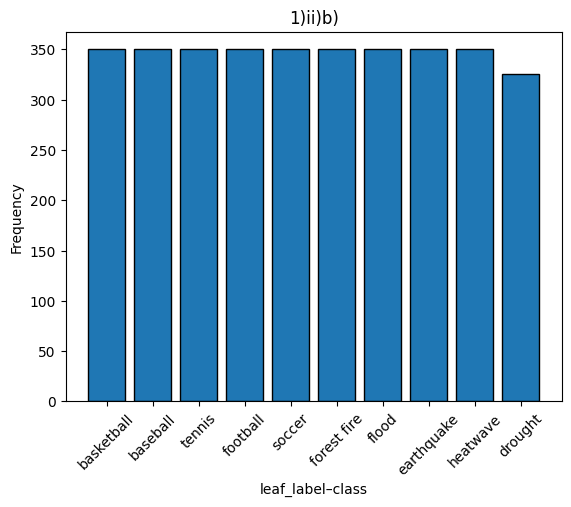

In [48]:
plt.bar(
    df['leaf_label'].value_counts().index.astype(str),
    df['leaf_label'].value_counts().values,
    edgecolor = 'black'
)
plt.title('1)ii)b)')
plt.xlabel('leaf_label–class')
plt.xticks(rotation=45)
plt.ylabel('Frequency')


### Ans (c):

Text(0, 0.5, 'Frequency')

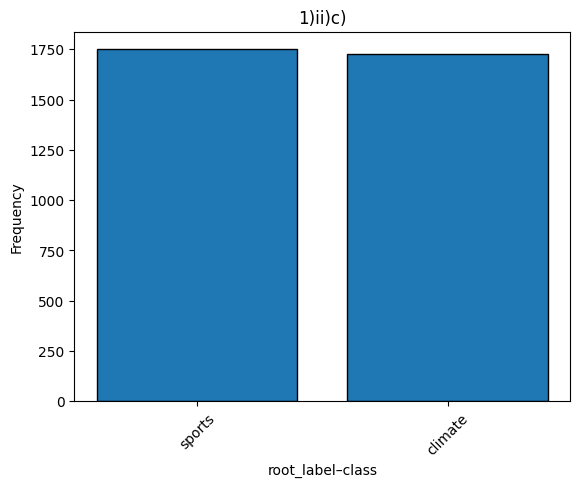

In [49]:
plt.bar(
    df['root_label'].value_counts().index.astype(str),
    df['root_label'].value_counts().values,
    edgecolor = 'black'
)
plt.title('1)ii)c)')
plt.xlabel('root_label–class')
plt.xticks(rotation=45)
plt.ylabel('Frequency')

### iii) Provide qualitative interpretations of the histograms.

For plot (a), we can conclude that most (3060/3476*100 = 88.03%) of the data points have between 0 and 5000 alpha-numeric characters. For counts beyond 5000, there is approximately an exponential decrease in the frequency.

In plot (b), we are trying to ascertain the number of data points corresponding to each granular (or 'leaf'/low-level) label. It seems that the dataset is well-balanced between the 10 classes, which means that a model trained to classify a new data-point (as one of the 10 classes) should result in an unbiased multi-class classifier.

In plot (c), we are trying to ascertain the number of data points corresponding to each high-level (or 'root') label. Ofcourse, it follows from both the plot and our observation in plot (b), that our dataset is well-balanced between the 2 classes, which means that a model trained to classify a new data-point (as one of the 2 classes) should result in an unbiased binary classifier. 



# Question 2




In [58]:
np.random.seed(42)
random.seed(42)

In [59]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df[["full_text","root_label"]], test_size=0.2, random_state = 42)

### Storing and loading dfs to ensure consistency for collaborators (they will ignore everything upto this markdown section proceed directly from read _csv below)

In [60]:
train.to_csv('../data/train_df.csv', index=False)
test.to_csv('../data/test_df.csv', index=False)

# Lorenzo and Arthur will begin loading the data from here

In [2]:
train = pd.read_csv('../data/train_df.csv')
test = pd.read_csv('../data/test_df.csv')

### Report the number of training and testing samples.

### Ans:

In [3]:
print(f'There are {train.shape[0]} training samples.')
print(f'There are {test.shape[0]} testing samples.')


There are 2780 training samples.
There are 696 testing samples.


# Question 3

### Text cleaning:

In [4]:
import re
def clean(text):
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    texter = re.sub(r"<br />", " ", text)
    texter = re.sub(r"&quot;", "\"",texter)
    texter = re.sub('&#39;', "\"", texter)
    texter = re.sub('\n', " ", texter)
    texter = re.sub(' u '," you ", texter)
    texter = re.sub('`',"", texter)
    texter = re.sub(' +', ' ', texter)
    texter = re.sub(r"(!)\1+", r"!", texter)
    texter = re.sub(r"(\?)\1+", r"?", texter)
    texter = re.sub('&amp;', 'and', texter)
    texter = re.sub('\r', ' ',texter)
    clean = re.compile('<.*?>')
    texter = texter.encode('ascii', 'ignore').decode('ascii')
    texter = re.sub(clean, '', texter)
    if texter == "":
        texter = ""
    return texter

print(train.head())
print(test.head())

train['full_text'] = train['full_text'].apply(
    lambda row: clean(row)
)
test['full_text'] = test['full_text'].apply(
    lambda row: clean(row)
)
print(train.head())
print(test.head())

                                           full_text root_label
0  'While the four-day Aftershock's economic impa...    climate
1  'CBS Essentials is created independently of th...     sports
2  'Moderate-to-severe drought will likely contin...    climate
3  'Colleen Flood, the longtime co-owner of The F...    climate
4  'WASHINGTON TRAFFIC MAY HAVE SAVED HIS LIFE. Y...     sports
                                           full_text root_label
0  'A small patch of snow on the ground in Douai,...    climate
1  'Antonio Zago, of Brazil, puts on a jersey dur...     sports
2  'NEW YORK >> The Las Vegas Aces became the fir...     sports
3  'Christian Abraham/Hearst Connecticut Media\n\...    climate
4  'The City of Watertown is currently under a wa...    climate
                                           full_text root_label
0  'While the four-day Aftershock's economic impa...    climate
1  'CBS Essentials is created independently of th...     sports
2  'Moderate-to-severe drought will like

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
from nltk.corpus import wordnet
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

lemmatizer = WordNetLemmatizer()
vectorizer = CountVectorizer(stop_words='english',min_df=3)
tfidf_transformer = TfidfTransformer()

def penn2morphy(penntag): #reference: discussion notebook
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 

def lemmatizer_func(sentence): 
    lemmatized_sen = []
    lemma_list = [lemmatizer.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(word_tokenize(sentence))]
    for lemma in lemma_list:
        if (not any(char in lemma for char in punctuation) and not any(char.isdigit() for char in lemma)):
            lemmatized_sen.append(lemma.lower())
    return ' '.join(lemmatized_sen)   